## Neural Net for combined Copy Number Variation and RNAseq

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

### Import and Process Data

In [2]:
working_directory = '/Users/a.su/Documents/MultiClassCancer_RNAseq_CNV_lncRNA/'

#Import Data
y = pd.read_table(working_directory + 'CancerTypes_y_BinaryClass.txt', sep = '\t', header = None)
x_cnv = pd.read_table(working_directory + 'CNV_processed_multiClass.txt', sep = '\t', header = 0)
x_rna = pd.read_table(working_directory + 'RNAseq_processed_multiClass.txt', sep = '\t', header = 0)
x_lnc = pd.read_table(working_directory + 'lncRNA_processed_multiClass.txt', sep = '\t', header = 0)

/Users/a.su/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Remove GeneID Column
x_cnv = x_cnv.drop('GeneID', axis = 1)
x_rna = x_rna.drop('GeneID', axis = 1)
x_lnc = x_lnc.drop('GeneID', axis = 1)

# Transpose
x_cnv = x_cnv.transpose()
x_rna = x_rna.transpose()
x_lnc = x_lnc.transpose()
print('x_cnv shape is:{0}  x_rna shape is:{1}  x_lnc shape is:{2}'.format(x_cnv.shape, x_rna.shape, x_lnc.shape))
print('y shape is:', y.shape)

x_cnv shape is:(668, 26374)  x_rna shape is:(668, 26094)  x_lnc shape is:(668, 21770)
y shape is: (668, 1)


In [4]:
drop_threshold = 0.5*len(x_cnv.index)

#DropNa from columns with at least 50% NaN
x_cnv_dropped = x_cnv.dropna(thresh = drop_threshold)
x_rna_dropped = x_rna.dropna(thresh = drop_threshold)
x_lnc_dropped = x_lnc.dropna(thresh = drop_threshold)

#Columns dropped
def print_dropped_columns(df, df_dropped, df_name):
    print('Dropped {0} Columns from {1}'.format(len(df.columns) - len(df_dropped.columns), df_name))

print_dropped_columns(x_cnv, x_cnv_dropped, 'x_cnv')
print_dropped_columns(x_rna, x_rna_dropped, 'x_rna')
print_dropped_columns(x_lnc, x_lnc_dropped, 'x_lnc')

Dropped 0 Columns from x_cnv
Dropped 0 Columns from x_rna
Dropped 0 Columns from x_lnc


In [5]:
#Impute 
impute_median = SimpleImputer(strategy = 'median')
x_cnv_imputed = pd.DataFrame(impute_median.fit_transform(x_cnv_dropped))
x_rna_imputed = pd.DataFrame(impute_median.fit_transform(x_rna_dropped))
x_lnc_imputed = pd.DataFrame(impute_median.fit_transform(x_lnc_dropped))

#Check for NaN values
print(np.isnan(x_cnv_imputed).all().any())
print(np.isnan(x_rna_imputed).all().any())
print(np.isnan(x_lnc_imputed).all().any())

False
False
False


In [6]:
def count_all_zeros (df, _axis_ = 0):
    return len(df.columns) - np.count_nonzero(df.sum(axis = _axis_), axis = _axis_)

#Count number of columns with all zeros
print('CNV: {0}  RNA: {1}  lnc: {2}'.format(count_all_zeros(x_cnv_imputed, 0), count_all_zeros(x_rna_imputed, 0), count_all_zeros(x_lnc_imputed, 0)))

CNV: 0  RNA: 111  lnc: 374


In [7]:
#Delete columns with all zeros
x_cnv_nozero = x_cnv_imputed.loc[:, (x_cnv_imputed != 0).any(axis = 0)]
x_rna_nozero = x_rna_imputed.loc[:, (x_rna_imputed != 0).any(axis = 0)]
x_lnc_nozero = x_lnc_imputed.loc[:, (x_lnc_imputed != 0).any(axis = 0)]

#Count number of column deletions
print_dropped_columns(x_cnv_imputed, x_cnv_nozero, 'x_cnv_imputed')
print_dropped_columns(x_rna_imputed, x_rna_nozero, 'x_rna_imputed')
print_dropped_columns(x_lnc_imputed, x_lnc_nozero, 'x_lnc_imputed')

Dropped 0 Columns from x_cnv_imputed
Dropped 111 Columns from x_rna_imputed
Dropped 374 Columns from x_lnc_imputed


In [8]:
#Count number of columns with all zeros
print('CNV: {0}  RNA: {1}  lnc: {2}'.format(count_all_zeros(x_cnv_nozero, 0), count_all_zeros(x_rna_nozero, 0), count_all_zeros(x_lnc_nozero, 0)))

CNV: 0  RNA: 0  lnc: 0


In [9]:
#Scale data
zscore = lambda x: (x-x.mean())/ x.std()

x_rna_processed, x_cnv_processed, x_lnc_processed = x_rna_nozero.transform(zscore), x_cnv_nozero.transform(zscore), x_lnc_nozero.transform(zscore)

In [10]:
#Visualise
x_rna_processed[np.random.choice(x_rna_processed.columns.values, size = 10, replace = False)].describe()

,14672,18052,20580,18549,2719,18332,9091,4592,12136,18279
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,1.020474e-16,2.227094e-16,7.813111e-16,4.175801e-17,-3.417094e-16,1.573259e-15,-4.356130e-16,3.639803e-16,-2.451466e-17,-1.349802e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.201311e+00,-3.993460e-01,-1.771311e+00,-2.388145e-01,-8.691430e-02,-1.563346e+00,-1.092004e+00,-2.737612e-01,-3.173229e-01,-1.610544e+00
25%,-7.329339e-01,-3.993460e-01,-5.956098e-01,-2.388145e-01,-8.691430e-02,-6.293582e-01,-5.589228e-01,-2.737612e-01,-3.173229e-01,-6.851349e-01
50%,-2.384287e-01,-3.993460e-01,-1.781259e-01,-2.183968e-01,-8.691430e-02,-2.080033e-01,-2.098671e-01,-2.704880e-01,-2.789276e-01,-1.818797e-01
75%,4.419763e-01,-2.656665e-01,3.451873e-01,-1.292290e-01,-8.691430e-02,3.658430e-01,2.618646e-01,-6.177871e-02,-1.052099e-01,4.084009e-01
max,4.670687e+00,7.892324e+00,1.290248e+01,1.951892e+01,1.873396e+01,1.096673e+01,1.193053e+01,1.390330e+01,1.635716e+01,7.075243e+00


In [11]:
x_cnv_processed[np.random.choice(x_cnv_processed.columns.values, size = 10, replace = False)].describe()

,21076,6210,20854,4698,1768,21843,24096,2005,21675,24633
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-3.397149e-16,-4.219845e-16,-5.337547e-16,-1.089448e-15,3.806004e-17,-3.643127e-16,-3.897415e-16,-3.084692e-16,-1.062025e-16,3.689663e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.381398e+00,-3.090586e+00,-1.986745e+00,-3.135119e+00,-2.604649e+00,-3.044525e+00,-3.058483e+00,-3.393235e+00,-2.028328e+00,-2.295783e+00
25%,-6.243816e-01,-6.339691e-01,-6.182360e-01,-6.784284e-01,-6.442062e-01,-6.757195e-01,-7.266223e-01,-6.095486e-01,-6.352684e-01,-6.346993e-01
50%,-1.182303e-01,8.924184e-02,-1.392608e-01,1.646195e-01,-1.585160e-01,7.224287e-02,-5.450844e-02,-1.257937e-01,3.055787e-03,-7.486381e-02
75%,5.092519e-01,5.891467e-01,4.776140e-01,6.441616e-01,5.401521e-01,5.620206e-01,6.533444e-01,5.894343e-01,4.615357e-01,3.985932e-01
max,4.463698e+00,4.177867e+00,8.399086e+00,2.828113e+00,4.123763e+00,4.148804e+00,4.713583e+00,3.407939e+00,7.191099e+00,6.717284e+00


In [12]:
x_lnc_processed[np.random.choice(x_lnc_processed.columns.values, size = 10, replace = False)].describe()

,9170,16457,1703,33,14320,1991,6639,12017,5202,6811
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,1.989115e-16,-1.893030e-16,-8.442182e-16,4.783266e-16,8.569326e-16,6.245836e-16,2.660546e-15,-8.509494e-17,3.901570e-16,3.398812e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.940287e-02,-1.458500e-01,-1.468573e+00,-9.232185e-01,-9.084244e-01,-3.148980e-01,-2.023992e+00,-7.250077e-01,-6.568212e-01,-1.455076e-01
25%,-9.940287e-02,-1.458500e-01,-7.380860e-01,-6.525047e-01,-6.434925e-01,-3.148980e-01,-6.896770e-01,-5.909244e-01,-5.118673e-01,-1.455076e-01
50%,-9.711095e-02,-1.458500e-01,-2.059913e-01,-2.697507e-01,-3.296807e-01,-3.148980e-01,-1.145508e-01,-3.314364e-01,-2.730146e-01,-1.455076e-01
75%,-8.578878e-02,-1.106315e-01,4.755136e-01,2.764192e-01,2.638017e-01,-3.148980e-01,5.289162e-01,2.424804e-01,1.098308e-01,-1.455076e-01
max,1.917437e+01,2.083343e+01,6.293982e+00,7.454403e+00,6.899406e+00,1.290742e+01,4.383630e+00,1.013575e+01,1.044517e+01,2.029958e+01


In [13]:
#Check for NaN values
print('CNV: {0}  RNA: {1}  lnc: {2}'.format(
    x_cnv_processed.isnull().any().any(), x_rna_processed.isnull().any().any(), x_lnc_processed.isnull().any().any()))

CNV: False  RNA: False  lnc: False


In [14]:
#Reset Indexes for dataframes
def reset_df_index(df):
    df = df.reset_index(drop = True)
map(reset_df_index, [x_cnv_processed, x_rna_processed, x_lnc_processed])

In [15]:
#Combine data as pairs
x_cr = pd.concat([x_cnv_processed, x_rna_processed], axis = 1)
x_cl = pd.concat([x_cnv_processed, x_lnc_processed], axis = 1)
x_rl = pd.concat([x_rna_processed, x_lnc_processed], axis = 1)

print('x_cr shape is:{0}  x_cl shape is:{1}  x_rl shape is:{2}'.format(x_cr.shape, x_cl.shape, x_rl.shape))

x_cr shape is:(668, 52357)  x_cl shape is:(668, 47770)  x_rl shape is:(668, 47379)


In [16]:
#Combine all data 
x_all = pd.concat([x_cnv_processed, x_rna_processed, x_lnc_processed], axis = 1)
x_all.shape

(668, 73753)

### Neural Net

In [19]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

In [18]:
#Split data into training and test sets
x_combined_train, x_combined_test, y_combined_train, y_combined_test = train_test_split(
    x_all, y.values.flatten(), test_size = 0.25, random_state = 0)

In [38]:
"""
Best settings so far are:

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

Accuracy ~81.4%

model.add(Dense(16, activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(16, activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

Accuracy ~82% with 150 epochs
"""

model = Sequential()
#model.add(Dense(16, activation = 'tanh'))
#model.add(Dropout(0.3))
#model.add(Dense(16, activation = 'tanh'))
#model.add(Dropout(0.3))
#model.add(Dense(32, activation = 'relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer = regularizers.l1(0.1)))

In [39]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.fit(x_combined_train.values, y_combined_train, epochs = 200, batch_size = 64, verbose = 1)

Epoch 1/200
501/501 [==============================] - 1s 3ms/step - loss: 20.5489 - acc: 0.5569
Epoch 2/200
501/501 [==============================] - 1s 2ms/step - loss: 7.4053 - acc: 0.6607
Epoch 3/200
501/501 [==============================] - 1s 2ms/step - loss: 5.2345 - acc: 0.6347
Epoch 4/200
501/501 [==============================] - 1s 2ms/step - loss: 3.6581 - acc: 0.5908
Epoch 5/200
501/501 [==============================] - 1s 2ms/step - loss: 2.9450 - acc: 0.5908
Epoch 6/200
501/501 [==============================] - 1s 2ms/step - loss: 2.5733 - acc: 0.5669
Epoch 7/200
501/501 [==============================] - 1s 2ms/step - loss: 2.3645 - acc: 0.5709
Epoch 8/200
501/501 [==============================] - 1s 2ms/step - loss: 2.2436 - acc: 0.5928
Epoch 9/200
501/501 [==============================] - 1s 2ms/step - loss: 2.2119 - acc: 0.5988
Epoch 10/200
501/501 [==============================] - 1s 2ms/step - loss: 2.2326 - acc: 0.5808
Epoch 11/200
501/501 [================

In [37]:
model.evaluate(x_combined_test, y_combined_test)

167/167 [==============================] - 0s 2ms/step


[1.2944372399838384, 0.8023952102946664]

In [32]:
model.metrics_names

['loss', 'acc']

In [28]:
import matplotlib.pyplot as plt

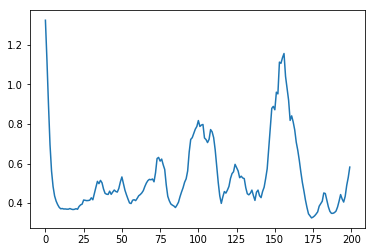

In [33]:
plt.plot(model.history.epoch, model.history.history['loss'])
plt.show()

### Comparison of different data sets with one model

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
#Datasets and corresponding labels
Datasets = [
    [x_cnv_processed, 'CNV Only'],
    [x_rna_processed, 'RNA Only'],
    [x_lnc_processed, 'lnc Only'],
    [x_cr, 'CNV and RNA'],
    [x_cl, 'CNV and lnc'],
    [x_rl, 'RNA and lnc'],
    [x_all, 'CNV, RNA and lnc']
]

In [38]:
for df, label in Datasets:
    x_train, x_test, y_train, y_test = train_test_split(df, y.values.flatten(), test_size = 0.25, random_state = 0)
    model = Sequential()
    model.add(Dense(16, activation = 'tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation = 'tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(x_train.values, y_train, epochs = 150, batch_size = 128, verbose = 0)
    print(label, model.evaluate(x_test, y_test, verbose = 0))
    
    

CNV Only [0.6747740771242244, 0.7425149711306224]
RNA Only [0.8499456329973872, 0.7245508985605068]
lnc Only [1.2996799467566484, 0.598802396280323]
CNV and RNA [0.5016457552681426, 0.7964071863425706]
CNV and lnc [0.628189865343585, 0.7544910186778999]
RNA and lnc [0.7763335169432406, 0.7065868274180475]
CNV, RNA and lnc [0.5762685444540606, 0.7544910186778999]
